In [2]:
import pandas as pd
import seaborn as sns

import nltk
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

nltk.download('punkt')
# !python3 -m spacy download en

[nltk_data] Downloading package punkt to /Users/marcus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

color_pallete = sns.color_palette([grey, darkgreen, teal, blue, yellow])

# Feedback Analysis

In [4]:
feedback_df = pd.read_csv('../Menagerie/data/grades.csv', index_col=0)
feedback_df = feedback_df[~feedback_df['grade'].isnull()]
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++
16,353.0,NaN,Documentation,14,1,A++
17,422.0,NaN,Documentation,14,1,A++
18,480.0,NaN,Documentation,14,1,A++


## Multiple Graders

In [5]:
def map_participant_group(participant_id):
    if participant_id <= 4:
        return "1-4"
    elif 4 < participant_id <= 8:
        return "5-8"
    elif 8 < participant_id <= 12:
        return "9-12"
    elif 12 < participant_id <= 16:
        return "13-16"
    elif 16 < participant_id <= 20:
        return "17-20"
    elif 20 < participant_id <= 24:
        return "21-24"
    elif 24 < participant_id <= 28:
        return "25-28"

feedback_df['group'] = feedback_df['participant_id'].apply(map_participant_group)
feedback_df['group'] = pd.Categorical(feedback_df['group'], categories=['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
feedback_df = feedback_df.sort_values('group', ascending=True)
feedback_df.to_csv('../data/inter_rater.csv')
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade,group
0,302.0,The code demonstrates a high level of organisa...,Readability,3,2,A++,1-4
4,188.0,Some method names are misleading,Readability,2,2,B,1-4
3,542.0,NaN,Readability,2,2,A-,1-4
2,277.0,NaN,Readability,2,2,A-,1-4
1,303.0,NaN,Readability,2,2,A-,1-4
...,...,...,...,...,...,...,...
3,176.0,NaN,Readability,26,1,A++,25-28
4,619.0,NaN,Readability,26,1,A-,25-28
5,305.0,NaN,Readability,26,1,A+,25-28
5,305.0,The submission includes a large number of clas...,Documentation,28,1,A++,25-28


### Length

In [6]:
feedback_df['comments'] = feedback_df['comments'].fillna("No comment supplied")
feedback_df['length'] = feedback_df['comments'].apply(len)
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade,group,length
0,302.0,The code demonstrates a high level of organisa...,Readability,3,2,A++,1-4,108
4,188.0,Some method names are misleading,Readability,2,2,B,1-4,32
3,542.0,No comment supplied,Readability,2,2,A-,1-4,19
2,277.0,No comment supplied,Readability,2,2,A-,1-4,19
1,303.0,No comment supplied,Readability,2,2,A-,1-4,19
...,...,...,...,...,...,...,...,...
3,176.0,No comment supplied,Readability,26,1,A++,25-28,19
4,619.0,No comment supplied,Readability,26,1,A-,25-28,19
5,305.0,No comment supplied,Readability,26,1,A+,25-28,19
5,305.0,The submission includes a large number of clas...,Documentation,28,1,A++,25-28,211


/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_79954/641369842.py:1: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  length_plt = sns.boxplot(feedback_df[feedback_df['length'] < 550], x='group', y='length', hue='skill', dodge=True, palette=color_pallete, hue_order=['Correctness', 'Code Elegance', 'Readability', 'Documentation'])


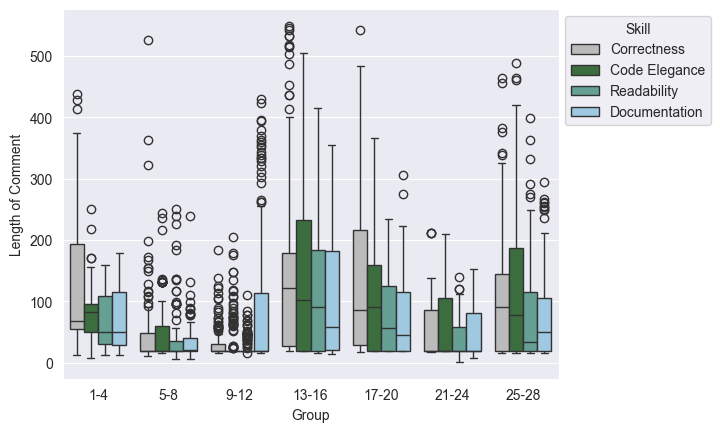

In [56]:
length_plt = sns.boxplot(feedback_df[feedback_df['length'] < 550], x='group', y='length', hue='skill', dodge=True, palette=color_pallete, hue_order=['Correctness', 'Code Elegance', 'Readability', 'Documentation'])
length_plt.set(xlabel='Group', ylabel='Length of Comment')
sns.move_legend(length_plt, "upper left", bbox_to_anchor=(1, 1), title='Skill')
length_plt.get_figure().savefig('../plots/inter_rater_length.pdf', bbox_inches='tight')

### Comment Similarity
- To clarify: does taking the mean cosine sim of each assignment and then plotting it make sense?

In [53]:
inter_rater_sim_df = pd.read_csv('../data/inter_rater_sim.csv')
inter_rater_sim_df = inter_rater_sim_df[~((inter_rater_sim_df['feedback_1'] == 'No comment supplied' ) & (inter_rater_sim_df['feedback_2'] == 'No comment supplied'))]
inter_rater_sim_df = inter_rater_sim_df[['group', 'assignment_number', 'skill', 'sim']].groupby(['group', 'assignment_number', 'skill']).mean().reset_index()
inter_rater_sim_df.head(20)

,group,assignment_number,skill,sim
0,1-4,29.0,Code Elegance,0.290893
1,1-4,29.0,Correctness,0.346559
2,1-4,29.0,Documentation,0.270871
3,1-4,29.0,Readability,0.270871
4,1-4,36.0,Code Elegance,0.380823
5,1-4,36.0,Correctness,0.547184
6,1-4,36.0,Documentation,0.398740
7,1-4,36.0,Readability,0.484722
8,1-4,59.0,Code Elegance,0.363281
9,1-4,59.0,Correctness,0.445805


/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_79954/1960775852.py:1: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  g = sns.boxplot(inter_rater_sim_df, x='group', y='sim', hue='skill', palette=color_pallete, hue_order=['Correctness', 'Code Elegance', 'Readability', 'Documentation'])


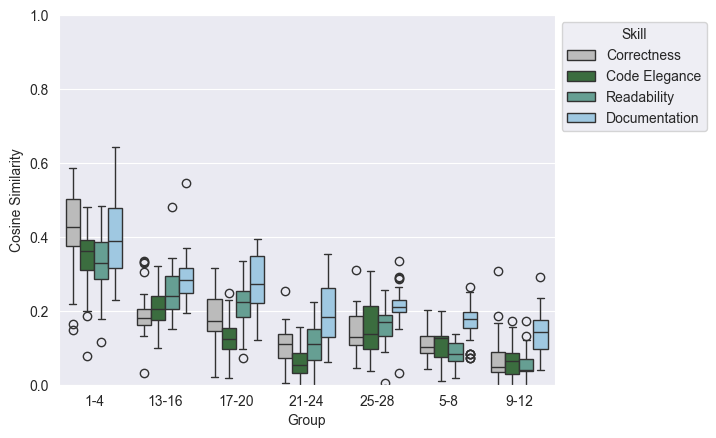

In [62]:
g = sns.boxplot(inter_rater_sim_df, x='group', y='sim', hue='skill', palette=color_pallete, hue_order=['Correctness', 'Code Elegance', 'Readability', 'Documentation'])
g.set(xlabel='Group', ylabel='Cosine Similarity', ylim=(0,1))
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title='Skill')
g.get_figure().savefig('../plots/inter_rater_sim.pdf', bbox_inches='tight')